# Portfolio Optimization

In [206]:
#runtime variable
gurobi_runtime = 3600

In [452]:
import pandas as pd
import gurobipy as gp
import numpy as np

df_2019 = pd.read_csv('stocks2019.csv')
df_2020 = pd.read_csv('stocks2020.csv')

## Data Cleaning

In [453]:
#cleaning data for 2019 stocks
df_2019['Date'] = pd.to_datetime(df_2019.iloc[:, 0])
df_2019.drop(df_2019.columns[0], axis=1, inplace=True)
df_2019.set_index('Date', inplace=True)
df_2019 = df_2019.pct_change()
df_2019.dropna(inplace=True)

#cleaning data for 2020 stocks
df_2020['Date'] = pd.to_datetime(df_2020.iloc[:, 0])
df_2020.drop(df_2020.columns[0], axis=1, inplace=True)
df_2020.set_index('Date', inplace=True)
df_2020 = df_2020.pct_change()
df_2020.dropna(inplace=True)

/var/folders/dg/6wd3ry2j1fb95lvmv1fq_y8r0000gn/T/ipykernel_65882/2797395151.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2020['Date'] = pd.to_datetime(df_2020.iloc[:, 0])


## Correlation Matrix

In [454]:
#create correlation matrix
corr = df_2019.corr()
corr

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
NDX,1.000000,0.550882,0.743789,0.636806,0.484723,0.439779,0.756556,0.750196,0.820341,0.383198,...,0.546456,0.276449,0.716719,0.555717,0.467410,0.407591,0.556518,0.576661,0.118452,0.496687
ATVI,0.550882,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.743789,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.636806,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.484723,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.407591,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.556518,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.576661,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.118452,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552


## Stock Selection Model

In [455]:
m = 5
corr_mndxi = df_2019.iloc[:,1:].corr()
N = len(corr_mndxi)

xMod = gp.Model()
y = xMod.addMVar(N,vtype='B')
a = xMod.addMVar((N,N),vtype='B')

m_con = xMod.addConstr(gp.quicksum(y[j] for j in range(N)) == m)
one_rep_cons = xMod.addConstrs((gp.quicksum(a[i,j] for j in range(N))==1) for i in range(N))
best_rep_cons = xMod.addConstrs(a[i,j] <= y[j] for i in range(N) for j in range(N))

xMod.setObjective(gp.quicksum(corr_mndxi.iloc[i,j] * a[i,j] for i in range(N) for j in range(N)), sense=gp.GRB.MAXIMIZE)

xMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
xMod.optimize()

In [456]:
#a.x
y.x

array([-0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0., -0.,
       -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  0.,  1., -0., -0.,  1., -0., -0., -0.,  1., -0.,
       -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0.,  1., -0.])

In [457]:
xMod.objVal

54.839906522291095

In [458]:
fund_stocks = df_2019.iloc[:, 1:]
cols_to_select = [col for idx, col in enumerate(fund_stocks.columns) if y.x[idx] == 1]
fund_stocks = fund_stocks[cols_to_select]
fund_stocks

,LBTYK,MXIM,MSFT,VRTX,XEL
Date,,,,,
2019-01-03,-0.006280,-0.056845,-0.036788,-0.002133,-0.003940
2019-01-04,0.068546,0.044004,0.046509,0.054785,0.009786
2019-01-07,-0.042766,0.010388,0.001275,0.018240,-0.004330
2019-01-08,-0.036122,-0.015026,0.007251,0.013307,0.011597
2019-01-09,0.002959,0.027098,0.014300,0.023065,-0.007984
...,...,...,...,...,...
2019-12-23,0.004617,-0.004213,0.000000,-0.003217,-0.017615
2019-12-24,0.000919,-0.002604,-0.000191,0.002637,0.003913
2019-12-26,-0.016988,0.006526,0.008197,-0.001406,-0.001114


## Weight Selection Model

In [463]:
ndx_returns = df_2019.iloc[:, 0]
T = len(ndx_returns)
N = len(fund_stocks.columns)

mod = gp.Model()
w = mod.addMVar(N)
z = mod.addMVar(T)
q = ndx_returns

w_con = mod.addConstr(gp.quicksum(w[i] for i in range(N)) == 1)
z_cons1 = mod.addConstrs(z[t] >= q[t] - gp.quicksum(w[i] * fund_stocks.iloc[t, i] for i in range(N)) for t in range(T))
z_cons2 = mod.addConstrs(z[t] >= gp.quicksum(w[i] * fund_stocks.iloc[t, i] for i in range(N)) - q[t] for t in range(T))

mod.setObjective(gp.quicksum(z[t] for t in range(T)))

mod.Params.OutputFlag = 0 # tell gurobi to shut up!!
mod.optimize()

In [464]:
w.x

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

In [465]:
matching_columns = df_2020.columns.intersection(fund_stocks.columns)
fund_2020 = df_2020[matching_columns]
fund_2020

,LBTYK,MXIM,MSFT,VRTX,XEL
Date,,,,,
2020-01-03,-0.016204,-0.017299,-0.012452,-0.006699,0.004809
2020-01-06,0.015059,-0.018093,0.002585,0.027755,-0.001436
2020-01-07,-0.007881,0.022576,-0.009118,-0.001071,-0.002077
2020-01-08,-0.043458,-0.000325,0.015928,0.032620,-0.000961
2020-01-09,-0.024426,0.007308,0.012493,-0.003592,0.002244
...,...,...,...,...,...
2020-12-23,0.021102,-0.006828,-0.013039,0.004002,-0.008021
2020-12-24,0.003374,0.008856,0.007827,-0.005851,0.004976
2020-12-28,-0.003363,-0.000116,0.009921,-0.008488,0.010676


In [466]:
#track performance
ndx_returns20 = df_2020.iloc[:, 0]
N = len(fund_stocks.columns)
T = len(ndx_returns20)
pw = w.x

performance = 0
for t in range(T):
    daily_return = abs(ndx_returns20.iloc[t] - sum(pw[i] * fund_2020.iloc[t, i] for i in range(N)))
    performance += daily_return


print('Using',m,'stocks, the portfolio returns in 2020 differed from the NDX by',performance)


Using 5 stocks, the portfolio returns in 2020 differed from the NDX by 1.1124373455076468


## For Loop for m's

In [442]:
m_list = [5,10,20,30,40,50,60,70,80,90,100]
weight2020_list = []
m_fund2020_stocks = []
corr_mndx = df_2019.iloc[:,1:].corr()
#For Loop through m_list
for m in m_list:
    N = len(corr_mndx)
    #check to see if N is greater than m; needed for if csv has less stocks than m
    if m <= N:
        #Stock Selection Model
        xMod = gp.Model()
        y = xMod.addMVar(N,vtype='B')
        a = xMod.addMVar((N,N),vtype='B')

        m_con = xMod.addConstr(gp.quicksum(y[j] for j in range(N)) == m)
        one_rep_cons = xMod.addConstrs((gp.quicksum(a[i,j] for j in range(N))==1) for i in range(N))
        best_rep_cons = xMod.addConstrs(a[i,j] <= y[j] for i in range(N) for j in range(N))

        xMod.setObjective(gp.quicksum(corr_mndx.iloc[i,j] * a[i,j] for i in range(N) for j in range(N)), sense=gp.GRB.MAXIMIZE)

        xMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        xMod.optimize()

        fund_stocks = df_2019.iloc[:,1:]
        cols_to_select = [col for idx, col in enumerate(fund_stocks.columns) if y.x[idx] == 1]
        fund_stocks = fund_stocks[cols_to_select]

        #Weight Optimization Model
        ndx_returns = df_2019.iloc[:, 0]
        T = len(ndx_returns)
        N = len(fund_stocks.columns)

        mod = gp.Model()
        w = mod.addMVar(N)
        z = mod.addMVar(T)
        q = ndx_returns

        w_con = mod.addConstr(gp.quicksum(w[i] for i in range(N)) == 1)
        z_cons1 = mod.addConstrs(z[t] >= q[t] - gp.quicksum(w[i] * fund_stocks.iloc[t, i] for i in range(N)) for t in range(T))
        z_cons2 = mod.addConstrs(z[t] >= gp.quicksum(w[i] * fund_stocks.iloc[t, i] for i in range(N)) - q[t] for t in range(T))

        mod.setObjective(gp.quicksum(z[t] for t in range(T)))

        mod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        mod.optimize()

        #append to lists for tracking performance
        weight2020_list.append(w.x)
        matching_columns = df_2020.columns.intersection(fund_stocks.columns)
        fund_2020 = df_2020[matching_columns]
        m_fund2020_stocks.append(fund_2020)

    else:
        break

In [443]:
m_list = [5,10,20,30,40,50,60,70,80,90,100]
ndx_returns20 = df_2020.iloc[:, 0]
performance_list_2020 = []

for index, m in enumerate(m_list):
    performance = 0
    current_weights = weight2020_list[index]
    current_stocks = m_fund2020_stocks[index]
    
    for t in range(T):
        daily_return = abs(ndx_returns20.iloc[t] - sum(current_weights[i] * current_stocks.iloc[t, i] for i in range(m)))
        performance += daily_return
    print('Using', m, 'stocks, the portfolio returns in 2020 differed from the NDX by', performance)
    performance_list_2020.append(performance)

Using 5 stocks, the portfolio returns in 2020 differed from the NDX by 1.1094052880458731
Using 10 stocks, the portfolio returns in 2020 differed from the NDX by 1.1005105422829375
Using 20 stocks, the portfolio returns in 2020 differed from the NDX by 0.8986913274869651
Using 30 stocks, the portfolio returns in 2020 differed from the NDX by 0.7690422024877481
Using 40 stocks, the portfolio returns in 2020 differed from the NDX by 0.7902334894372435
Using 50 stocks, the portfolio returns in 2020 differed from the NDX by 0.7715017219818449
Using 60 stocks, the portfolio returns in 2020 differed from the NDX by 1.0937226036254222
Using 70 stocks, the portfolio returns in 2020 differed from the NDX by 0.5558132901371213
Using 80 stocks, the portfolio returns in 2020 differed from the NDX by 0.5350127398952811
Using 90 stocks, the portfolio returns in 2020 differed from the NDX by 0.3646083786824308
Using 100 stocks, the portfolio returns in 2020 differed from the NDX by 0.3654801685282862

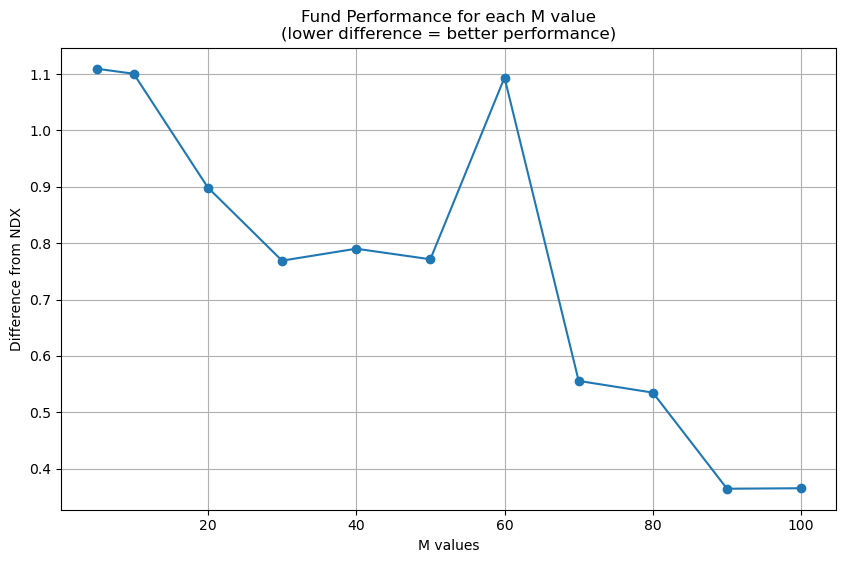

In [444]:
#graph how performance changes with different m values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(m_list, performance_list_2020, marker='o')
plt.title("Fund Performance for each M value\n(lower difference = better performance)")
plt.xlabel("M values")
plt.ylabel("Difference from NDX")
plt.grid(True)
plt.show()

## For Loop for m's for 2019 Performance

In [445]:
m_list = [5,10,20,30,40,50,60,70,80,90,100]
weight2019_list = []
m_fund2019_stocks = []
corr_mndx2 = df_2019.iloc[:,1:].corr()
#For Loop through m_list
for m in m_list:
    N = len(corr_mndx2)
    #check to see if N is greater than m; needed for if csv has less stocks than m
    if m <= N:
        #Stock Selection Model
        xMod = gp.Model()
        y = xMod.addMVar(N,vtype='B')
        a = xMod.addMVar((N,N),vtype='B')

        m_con = xMod.addConstr(gp.quicksum(y[j] for j in range(N)) == m)
        one_rep_cons = xMod.addConstrs((gp.quicksum(a[i,j] for j in range(N))==1) for i in range(N))
        best_rep_cons = xMod.addConstrs(a[i,j] <= y[j] for i in range(N) for j in range(N))

        xMod.setObjective(gp.quicksum(corr_mndx2.iloc[i,j] * a[i,j] for i in range(N) for j in range(N)), sense=gp.GRB.MAXIMIZE)

        xMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        xMod.optimize()

        fund_stocks = df_2019.iloc[:, 1:]
        cols_to_select = [col for idx, col in enumerate(fund_stocks.columns) if y.x[idx] == 1]
        fund_stocks = fund_stocks[cols_to_select]
        m_fund2019_stocks.append(fund_stocks)

        #Weight Optimization Model
        ndx_returns = df_2019.iloc[:, 0]
        T = len(ndx_returns)
        N = len(fund_stocks.columns)

        mod = gp.Model()
        w = mod.addMVar(N)
        z = mod.addMVar(T)
        q = ndx_returns

        w_con = mod.addConstr(gp.quicksum(w[i] for i in range(N)) == 1)
        z_cons1 = mod.addConstrs(z[t] >= q[t] - gp.quicksum(w[i] * fund_stocks.iloc[t, i] for i in range(N)) for t in range(T))
        z_cons2 = mod.addConstrs(z[t] >= gp.quicksum(w[i] * fund_stocks.iloc[t, i] for i in range(N)) - q[t] for t in range(T))

        mod.setObjective(gp.quicksum(z[t] for t in range(T)))

        mod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        mod.optimize()

        #append to list for tracking performance
        weight2019_list.append(w.x)

    else:
        break

In [446]:
m_list = [5,10,20,30,40,50,60,70,80,90,100]
performance_list_2019 = []

for index, m in enumerate(m_list):
    performance = 0
    current_weights = weight2019_list[index]
    current_stocks = m_fund2019_stocks[index]
    
    for t in range(T):
        daily_return = abs(ndx_returns.iloc[t] - sum(current_weights[i] * current_stocks.iloc[t, i] for i in range(m)))
        performance += daily_return
    print('Using', m, 'stocks, the portfolio returns in 2019 differed from the NDX by', performance)
    performance_list_2019.append(performance)

Using 5 stocks, the portfolio returns in 2019 differed from the NDX by 0.7891782824631473
Using 10 stocks, the portfolio returns in 2019 differed from the NDX by 0.7012177959266302
Using 20 stocks, the portfolio returns in 2019 differed from the NDX by 0.4788357879113357
Using 30 stocks, the portfolio returns in 2019 differed from the NDX by 0.4180147550230182
Using 40 stocks, the portfolio returns in 2019 differed from the NDX by 0.3705172225552055
Using 50 stocks, the portfolio returns in 2019 differed from the NDX by 0.3325400929154758
Using 60 stocks, the portfolio returns in 2019 differed from the NDX by 0.34488997906451374
Using 70 stocks, the portfolio returns in 2019 differed from the NDX by 0.16982371827530907
Using 80 stocks, the portfolio returns in 2019 differed from the NDX by 0.14768252800096168
Using 90 stocks, the portfolio returns in 2019 differed from the NDX by 0.053779189845472315
Using 100 stocks, the portfolio returns in 2019 differed from the NDX by 0.04491115168

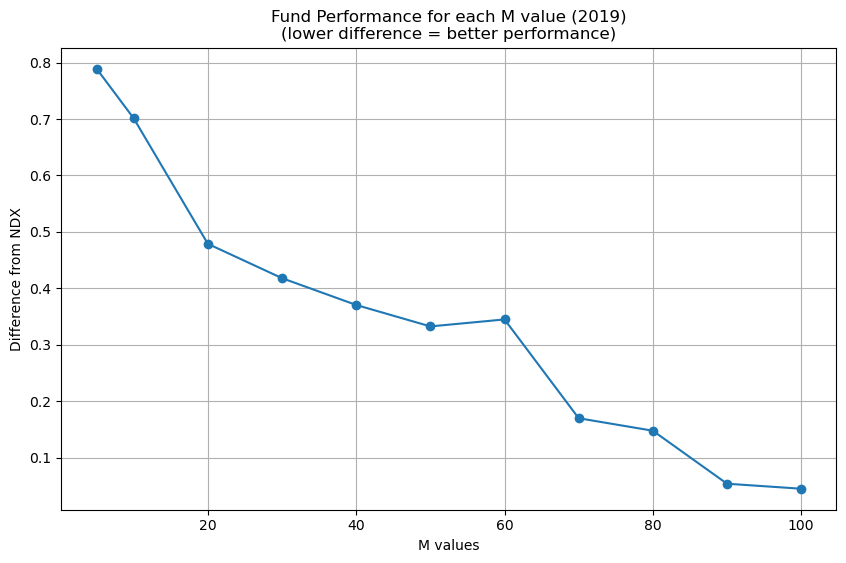

In [447]:
#graph how performance changes with different m values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(m_list, performance_list_2019, marker='o')
plt.title("Fund Performance for each M value (2019)\n(lower difference = better performance)")
plt.xlabel("M values")
plt.ylabel("Difference from NDX")
plt.grid(True)
plt.show()

## Weight Opt Model over all Weights

In [222]:
import os
import csv
m_list = [5,10,20,30,40,50,60,70,80,90,100]
stocks_2019 = df_2019.iloc[:, 1:]
weight_list = []
m_fund_stocks2019 = []
m_fund_stocks2020 = []
M = 2

# Check if the CSV file exists
if os.path.exists('fund_stocks2020.csv'):
    fund_stocks2020 = pd.read_csv('fund_stocks2020.csv')
else:
    #For Loop through m_list
    for m in m_list:
        N = len(stocks_2019.columns)
        T = len(ndx_returns)
        #check to see if N is greater than m; needed for if csv has less stocks than m
        if m <= N:

            d = gp.Model()
            y = d.addMVar(N,vtype='B')
            w = d.addMVar(N)
            z = d.addMVar(T)
            q = ndx_returns

            #original constraints
            w_con = d.addConstr(gp.quicksum(w[i] for i in range(N)) == 1)
            z_cons1 = d.addConstrs(z[t] >= q[t] - gp.quicksum(w[i] * stocks_2019.iloc[t, i] for i in range(N)) for t in range(T))
            z_cons2 = d.addConstrs(z[t] >= gp.quicksum(w[i] * stocks_2019.iloc[t, i] for i in range(N)) - q[t] for t in range(T))

            #new constraints
            bigMcons = d.addConstrs((w[i] <= M*y[i]) for i in range(N))
            m_con = d.addConstr(gp.quicksum(y[i] for i in range(N)) == m)

            d.setObjective(gp.quicksum(z[t] for t in range(T)))

            #when testing need use a smaller runtime
            d.Params.OutputFlag = 1 # tell gurobi to shut up!!
            d.Params.TimeLimit = gurobi_runtime
            
            d.optimize()

            #append to lists for tracking performance
            print(w.x)
            weight_list.append(w.x)
            fund_stocks = df_2019.iloc[:, 1:]
            cols_to_select = [col for idx, col in enumerate(fund_stocks.columns) if y.x[idx] == 1]
            fund_stocks = fund_stocks[cols_to_select]
            m_fund_stocks2019.append(fund_stocks)
            matching_columns = df_2020.columns.intersection(fund_stocks.columns)
            fund_2020 = df_2020[matching_columns]
            m_fund_stocks2020.append(fund_2020)

        else:
            break
        

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 602 rows, 450 columns and 50708 nonzeros
Model fingerprint: 0xc07cf099
Variable types: 350 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [2e-05, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Found heuristic solution: objective 1.9064653
Presolve time: 0.03s
Presolved: 602 rows, 450 columns, 50708 nonzeros
Variable types: 350 continuous, 100 integer (100 binary)

Root relaxation: objective 4.491082e-02, 1582 iterations, 0.08 seconds (0.28 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.04491    0   84    1.90647    0.04491  97.6%     -  

In [223]:
#weights to csv
weight_df = pd.DataFrame(weight_list)
weight_df.to_csv('fund_weights.csv', index=False)

#fund stocks 2019 to csv
df_list = [pd.DataFrame(inner_list) for inner_list in m_fund_stocks2019]
fund_stocks2019_df = pd.concat(df_list, axis=0)
concatenated_df.to_csv('fund_stocks2019.csv', index=False)

#fund stocks 2020 to csv
df_list2 = [pd.DataFrame(inner_list) for inner_list in m_fund_stocks2020]
fund_stocks2020_df = pd.concat(df_list2, axis=0)
fund_stocks2020_df.to_csv('fund_stocks2020.csv', index=False)

## Performance of Opt Model over all Weights

In [230]:
m_list = [5,10,20,30,40,50,60,70,80,90,100]
ndx_returns20 = df_2020.iloc[:, 0]
sm_performance_list_2020 = []

for index, m in enumerate(m_list):
    performance = 0
    current_weights = weight_list[index]
    current_stocks = m_fund_stocks2020[index]
    
    for t in range(T):
        daily_return = abs(ndx_returns20.iloc[t] - sum(current_weights[i] * current_stocks.iloc[t, i] for i in range(m)))
        performance += daily_return
    print('Using', m, 'stocks, the portfolio returns in 2020 differed from the NDX by', performance)
    sm_performance_list_2020.append(performance)


Using 5 stocks, the portfolio returns in 2020 differed from the NDX by 3.85960268230893
Using 10 stocks, the portfolio returns in 2020 differed from the NDX by 2.7532511777227135
Using 20 stocks, the portfolio returns in 2020 differed from the NDX by 2.6278478300543724
Using 30 stocks, the portfolio returns in 2020 differed from the NDX by 2.2973026065757542
Using 40 stocks, the portfolio returns in 2020 differed from the NDX by 2.437264725717746
Using 50 stocks, the portfolio returns in 2020 differed from the NDX by 1.9103088794085954
Using 60 stocks, the portfolio returns in 2020 differed from the NDX by 1.5238956133512607
Using 70 stocks, the portfolio returns in 2020 differed from the NDX by 1.3620862217123766
Using 80 stocks, the portfolio returns in 2020 differed from the NDX by 1.1233228495593865
Using 90 stocks, the portfolio returns in 2020 differed from the NDX by 1.1850578231133433
Using 100 stocks, the portfolio returns in 2020 differed from the NDX by 0.3654801685282836


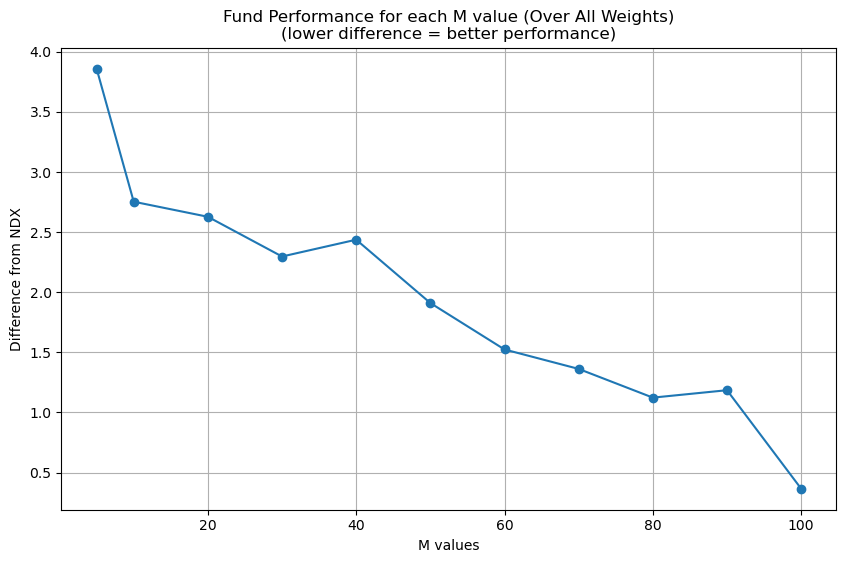

In [356]:
plt.figure(figsize=(10, 6))
plt.plot(m_list, sm_performance_list_2020, marker='o')
plt.title("Fund Performance for each M value (Over All Weights)\n(lower difference = better performance)")
plt.xlabel("M values")
plt.ylabel("Difference from NDX")
plt.grid(True)
plt.show()

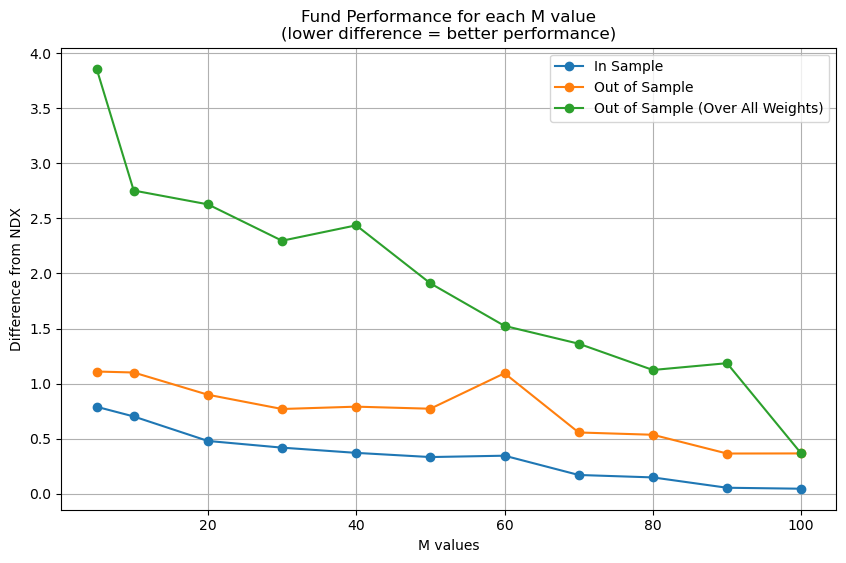

In [448]:
new_list = [performance_list_2019, performance_list_2020, sm_performance_list_2020]

# Plotting the data
plt.figure(figsize=(10, 6))

for y_values in new_list:
    plt.plot(m_list, y_values, marker='o')

plt.title("Fund Performance for each M value\n(lower difference = better performance)")
plt.xlabel("M values")
plt.ylabel("Difference from NDX")
plt.legend(["In Sample", "Out of Sample", "Out of Sample (Over All Weights)"])  # You can customize legend labels as needed
plt.grid(True)
plt.show()